## Machine Learning Model Using Sentinel-2 Data
### Author: Kavina Peters
### Purpose: Using Sentinel 2 spatial dataset from Planet.com, Vegetation Indices from Google Earth Engine API, ground truth Soil Organic Carbon (SOC), and farmer surveys to construct a Random Forest ML model aimed at predicting SOC Sequestration over time.
#### https://github.com/ktpeters/SOC-Change-in-Farmer-Fields-22-23

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.1 MB/s eta 0:00:00


In [ ]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 6.6 MB/s eta 0:00:00


In [ ]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.transform
import rasterio.mask
import rasterio.warp
import rasterio.windows
import rasterstats
import pandas as pd
from scipy.signal import savgol_filter

# for 3d plotting
from mpl_toolkits.mplot3d import Axes3D
# color
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

from rasterstats import zonal_stats
from shapely.geometry import LineString
from rasterio import features
from shapely.geometry import shape

# Machine Learning
import scipy as sp
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

### Define Functions

In [ ]:
def smooth_group(group, list_var, window_length=7, polyorder=2):
    """
    Applies Savitzky-Golay smoothing to each column of the
    DataFrame after sorting by date.
    Inputs:
    - group: a group in the dataframe
    - list_var: a list of variable names to smooth
    - window_length, polyorder: smoothing parameters
    """
    # Ensure the group is sorted by date
    group_sorted = group.sort_values('date')
    smoothed = group_sorted.copy()
    for column in list_var:
        # Apply an exponential moving average with a span of 7 days
        smoothed[column+'_ewm'] = smoothed[column].ewm(span=window_length,
                                                      adjust=False).mean()
        # Apply Savitzky-Golay filter
        smoothed[column+'_savgol'] = savgol_filter(smoothed[column],
                                     window_length=window_length,
                                     polyorder=polyorder)
        smoothed.loc[:, column+'_savgol'] = smoothed.loc[:, column+'_savgol'].fillna(smoothed[column+'_ewm'])
        smoothed.drop(columns=[column+'_ewm'], inplace=True)
    return smoothed

### 1. Read in Sentinel-2 Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#address = r'DataOriginal\Vegetation Indices GEE'
address=r'/content/drive/MyDrive/Vegetation Indices GEE'
list_df = []
list_error = []
for i in os.listdir(address):
    print(i)
    try:
        file_path = os.path.join(address, i)
        df = pd.read_csv(file_path, header=0)
        df = df[['date', 'path', 'B1', 'B11', 'B12',
                 'B2', 'B3', 'B4', 'B5', 'B6',
                 'B7', 'B8', 'B8A', 'B9', 'NDVI',
                 'TVI', 'EVI', 'SATVI', 'SAVI', 'MSI',
                 'GNDVI', 'GRVI', 'LSWI', 'MSAVI2', 'WDVI', 'BI',
                 'BI2', 'RI', 'CI', 'V']].copy()
        df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
        df['year'] = [x.year for x in df['date']]
        df['month'] = [x.month for x in df['date']]
        df['fieldID'] = ['10208071' if x=='C:/Users/Admin/Desktop/Shapefiles-20230504T062202Z-001/Shapefiles/10208071/10208071 shapefile.shp'
                         else '20412107' if x=='C:/Users/Admin/Desktop/Shapefiles-20230504T062202Z-001/Shapefiles/20412107|layername=20412107'
                         else x[-12:-4] for x in df['path']]
        df.drop(columns=['path'], inplace=True)
        list_df.append(df)
    except:
        list_error.append(i)

VegInd2017.csv
VegInd2018.csv
VegInd2020.csv
VegInd2019.csv
VegInd2021.csv
VegInd2023.csv
VegInd2022.csv


In [ ]:
df = pd.concat(list_df)

In [ ]:
df

,date,B1,B11,B12,B2,B3,B4,B5,B6,B7,...,MSAVI2,WDVI,BI,BI2,RI,CI,V,year,month,fieldID
0,2020-01-08,0.080198,0.337689,0.275879,0.101614,0.125266,0.148749,0.180601,0.203738,0.221983,...,0.048573,0.157165,0.097251,0.100822,11.349956,0.085585,1.560411,2020,1,10103011
1,2020-01-08,0.080504,0.307982,0.257439,0.099120,0.124119,0.148650,0.175442,0.194858,0.211920,...,0.040925,0.142752,0.096834,0.096989,11.600908,0.090041,1.461300,2020,1,10103016
2,2020-01-08,0.082089,0.335847,0.268976,0.102329,0.126006,0.152610,0.183701,0.204548,0.223513,...,0.047134,0.157173,0.098962,0.102042,11.677160,0.095374,1.532185,2020,1,10103020
3,2020-01-08,0.079799,0.338015,0.270889,0.099595,0.125164,0.150193,0.184368,0.206905,0.226285,...,0.051923,0.160460,0.097762,0.102053,11.557543,0.091026,1.569234,2020,1,10103027
4,2020-01-08,0.086475,0.316504,0.257218,0.099182,0.125237,0.146330,0.183581,0.208862,0.226598,...,0.056895,0.162966,0.096315,0.101588,10.937028,0.077550,1.615132,2020,1,10103028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,2022-12-28,0.068733,0.281232,0.202559,0.075785,0.104200,0.121291,0.156582,0.183041,0.198060,...,0.056214,0.136204,0.079976,0.084593,13.233660,0.076261,1.627351,2022,12,20616130
4481,2022-12-28,0.077174,0.369207,0.272299,0.097264,0.129542,0.177905,0.210634,0.224064,0.243107,...,0.047642,0.164799,0.110057,0.111990,14.700313,0.157434,1.427094,2022,12,20616131
4482,2022-12-28,0.075264,0.363647,0.265021,0.096265,0.126951,0.169976,0.206956,0.225122,0.247330,...,0.054459,0.170939,0.106099,0.110836,14.264266,0.144937,1.507613,2022,12,20616132
4483,2022-12-28,0.062978,0.255684,0.210715,0.074246,0.102948,0.130463,0.153782,0.165917,0.178732,...,0.036676,0.112177,0.083121,0.081080,15.909239,0.118396,1.362124,2022,12,20616133


In [ ]:
df.groupby('fieldID')

### 2. Smooth Vegetation Indices

In [ ]:
# List of variables to smooth
list_var = ['NDVI', 'TVI', 'EVI', 'SATVI', 'SAVI',
            'MSI', 'GNDVI', 'GRVI', 'LSWI', 'MSAVI2',
            'WDVI', 'BI', 'BI2', 'RI', 'CI', 'V']
# Apply the smoothing function to each group
df_smoothed = df.groupby('fieldID').apply(
    lambda group: smooth_group(group, list_var, window_length=7, polyorder=2),
    include_groups=False #changed---added
)

#df_smoothed= df_smoothed.reset_index(drop=True)
df_smoothed = df_smoothed.reset_index() #changed

In [ ]:
onesample = df_smoothed.loc[(df_smoothed.fieldID=='10103011')]

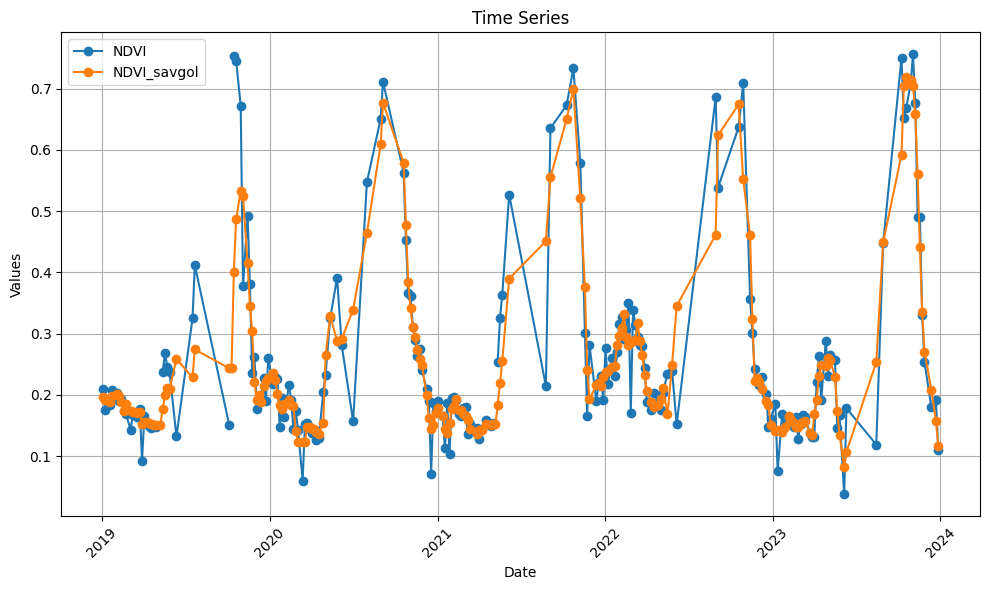

In [ ]:
# Plot the time series
plt.figure(figsize=(10, 6))

plt.plot(onesample['date'].values,
         onesample['NDVI'].values,
         label='NDVI', marker='o')
plt.plot(onesample['date'].values,
         onesample['NDVI_savgol'].values,
         label='NDVI_savgol', marker='o')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

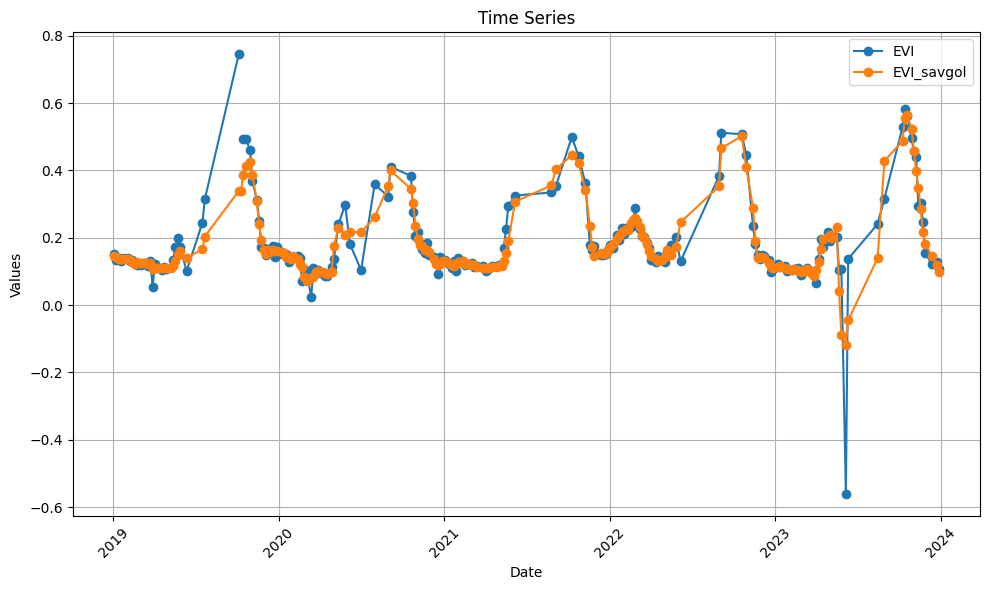

In [ ]:
# Plot the time series
plt.figure(figsize=(10, 6))

plt.plot(onesample['date'].values,
         onesample['EVI'].values,
         label='EVI', marker='o')
plt.plot(onesample['date'].values,
         onesample['EVI_savgol'].values,
         label='EVI_savgol', marker='o')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

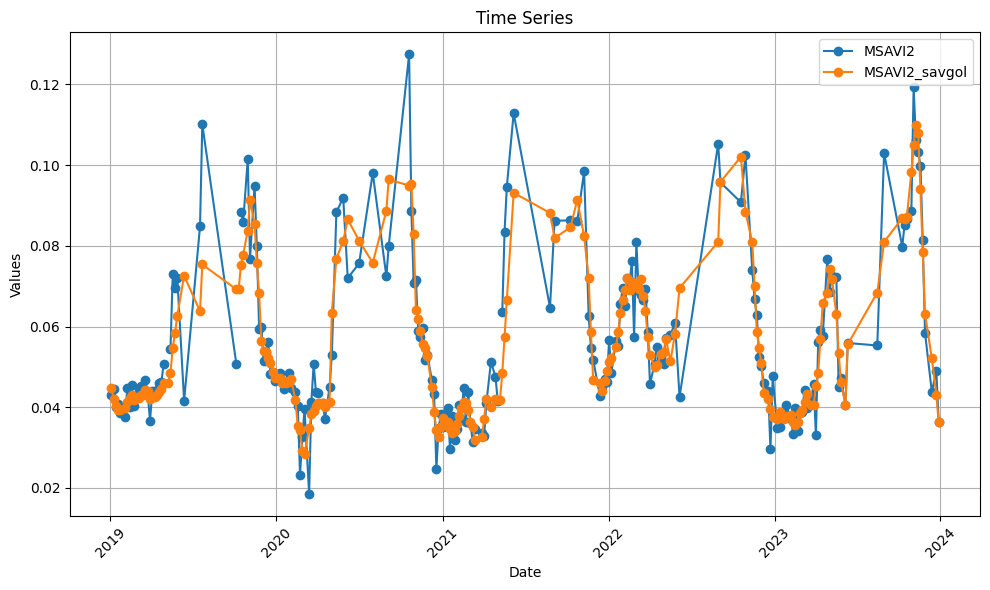

In [ ]:
# Plot the time series
plt.figure(figsize=(10, 6))

plt.plot(onesample['date'].values,
         onesample['MSAVI2'].values,
         label='MSAVI2', marker='o')
plt.plot(onesample['date'].values,
         onesample['MSAVI2_savgol'].values,
         label='MSAVI2_savgol', marker='o')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### 3. Long to Wide and Merge with Outcome Variables

In [ ]:
# Step 1: Filter Data for Growing Season
growing_season_mask = ((df_smoothed['month'] > 5) & (df_smoothed['month'] < 12))
growing_season_data = df_smoothed.loc[growing_season_mask].copy().reset_index(drop=True)

# Step 2: Group by 'fieldID' and 'year'

grouped = growing_season_data.groupby(['fieldID', 'year'])


# Step 3: Compute Aggregations
aggregated = grouped.agg(['max', 'min', 'median']).reset_index()

# Step 4: Flatten MultiIndex Columns
aggregated.columns = ['_'.join(col).strip() if col[1] else col[0]
                      for col in aggregated.columns.values]
aggregated.drop(columns=[#'level_1_max', 'level_1_min', 'level_1_median',
                         'date_max', 'date_min', 'date_median', 'month_max',
                         'month_min', 'month_median'],
                      #inplace=True)
)

,fieldID,year,level_1_max,level_1_min,level_1_median,B1_max,B1_min,B1_median,B11_max,B11_min,...,BI2_savgol_median,RI_savgol_max,RI_savgol_min,RI_savgol_median,CI_savgol_max,CI_savgol_min,CI_savgol_median,V_savgol_max,V_savgol_min,V_savgol_median
0,10101002,2019,4512,3132,3822.0,0.133631,0.038135,0.059169,0.305091,0.147529,...,0.104337,14.472021,8.466132,10.259228,0.069205,-0.098962,0.016644,5.315265,1.506106,2.151969
1,10101002,2020,4167,2672,3419.5,0.079571,0.024145,0.044308,0.244789,0.113950,...,0.094089,17.038934,9.798052,10.864988,0.094786,-0.053868,0.008724,4.206013,1.907681,2.783828
2,10101002,2021,3707,2787,3247.0,0.130795,0.025638,0.037257,0.240296,0.149619,...,0.105108,13.040875,9.916002,12.404776,0.107384,-0.040271,0.000121,3.886139,1.658534,3.010046
3,10101002,2022,3822,2902,3362.0,0.085208,0.033515,0.040898,0.245511,0.138949,...,0.101016,18.563813,10.289627,14.629596,0.126060,-0.040938,0.090583,3.797623,1.654003,2.486271
4,10101002,2023,4282,2787,3534.5,0.231989,0.018616,0.043355,0.325973,0.128295,...,0.104418,15.937932,6.633740,11.059591,0.119281,-0.138703,-0.046141,4.498811,1.678510,3.607124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,20616135,2019,4599,3219,3909.0,0.167956,0.033879,0.052568,0.386909,0.121400,...,0.109742,9.915639,4.459100,6.085735,0.062690,-0.231096,-0.103354,6.224805,1.171813,3.053926
571,20616135,2020,4254,2759,3506.5,0.088242,0.011568,0.044111,0.334867,0.080114,...,0.087340,18.284843,7.489933,8.900829,0.115838,-0.181158,-0.046936,7.168699,1.853859,3.425078
572,20616135,2021,3794,2874,3334.0,0.172051,0.022961,0.039275,0.253326,0.098654,...,0.092337,14.005416,8.917235,10.724652,0.058689,-0.093023,0.008976,4.683119,1.712291,2.524287
573,20616135,2022,3909,2989,3449.0,0.133743,0.028228,0.039691,0.318280,0.074762,...,0.096692,15.772282,6.925472,8.904270,0.052896,-0.149415,-0.056810,6.758629,1.394142,3.810715


In [ ]:
aggregated[aggregated['year']==2023]

,fieldID,year,level_1_max,level_1_min,level_1_median,date_max,date_min,date_median,B1_max,B1_min,...,BI2_savgol_median,RI_savgol_max,RI_savgol_min,RI_savgol_median,CI_savgol_max,CI_savgol_min,CI_savgol_median,V_savgol_max,V_savgol_min,V_savgol_median
4,10101002,2023,4282,2787,3534.5,2023-11-28,2023-06-06,2023-10-24,0.231989,0.018616,...,0.104418,15.937932,6.633740,11.059591,0.119281,-0.138703,-0.046141,4.498811,1.678510,3.607124
9,10101003,2023,4283,2788,3535.5,2023-11-28,2023-06-06,2023-10-24,0.125002,0.025142,...,0.104288,12.102430,5.750112,8.740681,0.091676,-0.147553,-0.053234,4.239539,1.579544,3.341208
14,10101004,2023,4284,2789,3536.5,2023-11-28,2023-06-06,2023-10-24,0.100533,0.021927,...,0.105109,11.445210,5.944758,7.420453,0.095850,-0.180608,-0.094886,5.139059,1.557105,3.840570
19,10101005,2023,4285,2790,3537.5,2023-11-28,2023-06-06,2023-10-24,0.257246,0.030807,...,0.107310,12.362989,5.191338,9.496177,0.121391,-0.127841,-0.041506,3.929052,1.479703,3.037048
24,10101006,2023,4286,2791,3538.5,2023-11-28,2023-06-06,2023-10-24,0.169822,0.017451,...,0.103755,13.966578,5.205480,8.584687,0.122471,-0.187133,-0.082839,5.151900,1.426404,3.849441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,20616130,2023,4365,2870,3617.5,2023-11-28,2023-06-06,2023-10-24,0.308519,0.010283,...,0.101279,14.134612,4.751609,8.695229,0.073007,-0.213228,-0.088140,8.907626,0.726987,4.244914
559,20616131,2023,4366,2871,3618.5,2023-11-28,2023-06-06,2023-10-24,0.338712,0.000787,...,0.100679,15.684108,5.791683,8.838790,0.122248,-0.184762,-0.038339,6.780248,0.989567,3.792429
564,20616132,2023,4367,2872,3619.5,2023-11-28,2023-06-06,2023-10-24,0.418513,0.001705,...,0.105365,19.702887,4.551495,11.264232,0.138804,-0.187003,0.003189,5.788982,1.072037,3.652629
569,20616133,2023,4368,2873,3620.5,2023-11-28,2023-06-06,2023-10-24,0.327473,0.000680,...,0.091192,14.338852,5.322865,7.860970,0.067499,-0.228735,-0.102034,9.265841,0.833827,3.605624


In [ ]:
# Read the yield and SOC data
file_path = r'/content/drive/MyDrive/crop-yield-estimations-20-23.dta'
yield_df = pd.read_stata(file_path)

file_path = r'/content/drive/MyDrive/n111_soc_2022_data.dta'
SOC22_df = pd.read_stata(file_path)

#file_path = r'/content/drive/MyDrive/reshaped_SOC_data_23.csv'
file_path = r'/content/drive/MyDrive/n30_appended_soc_data_nrri_04032024.dta'
SOC23_df = pd.read_stata(file_path)


In [ ]:
'''first30_22data=[]
for x in range(30):
    first30_22data.append(SOC22_df.iloc[x])

SOC23_df = pd.DataFrame(first30_22data,  columns = ["unique_id", "SOC_015",	"BDMgm3_015",	"SOC_stock_t_Cha_015",
              "SOC_1530",	"BD_Mgm3_1530",	"SOC_stock_t_Cha_1530"])
SOC23_df.head()
'''
SOC23_df

,unique_id,ml_soc_percent_015,ml_soc_percent_1530,ml_bd_015,ml_bd_1530,ml_soc_stock_015,ml_soc_stock_1530,assignment,treatment_merge,bl_SOC_015,bl_BDMgm3_015,bl_SOC_stock_t_Cha_015,bl_SOC_1530,bl_BD_Mgm3_1530,bl_SOC_stock_t_Cha_1530,bl_ml_merge
0,10103012,0.54600,0.3900,1.349091,1.416970,11.049055,8.289273,Control,matched (3),0.55,1.35,11.14,0.39,1.4000,8.29,matched (3)
1,10106054,0.58500,0.3120,1.446667,1.523030,12.694501,7.127782,Control,matched (3),0.60,1.50,13.50,0.32,1.5600,7.57,matched (3)
2,10104035,0.58500,0.5655,1.459394,1.400000,12.806182,11.875501,Control,matched (3),0.57,1.46,12.48,0.56,1.4100,11.84,matched (3)
3,10103024,0.33150,0.3120,1.327879,1.336364,6.602878,6.254182,Control,matched (3),0.33,1.33,6.58,0.31,1.3700,6.39,matched (3)
4,10105047,0.58500,0.5460,1.374546,1.408485,12.061637,11.535491,Control,matched (3),0.55,1.38,11.39,0.54,1.4000,11.25,matched (3)
5,10104039,0.39000,0.2925,1.416970,1.370303,8.289273,6.012205,Control,matched (3),0.39,1.42,8.31,0.31,1.3730,6.32,matched (3)
6,10105049,0.56550,0.5265,1.412727,1.472121,11.983460,11.626078,Control,matched (3),0.58,1.42,12.35,0.56,1.4700,12.26,matched (3)
7,10104033,0.58500,0.5265,1.463636,1.370303,12.843410,10.821969,Control,matched (3),0.58,1.46,12.67,0.53,1.3125,10.37,matched (3)
8,10208073,0.58500,0.3900,1.302424,1.366061,11.428773,7.991455,Control,matched (3),0.58,1.34,11.66,0.44,1.3670,9.00,matched (3)
9,10103029,0.37050,0.3510,1.285455,1.370303,7.143914,7.214646,Control,matched (3),0.36,1.29,6.99,0.32,1.3790,6.64,matched (3)


In [ ]:
SOC22_df['year'] = 2022
SOC23_df['year'] = 2023

In [ ]:
SOC23_df.rename(columns={'bl_SOC_stock_t_Cha_015': 'SOC_stock_t_Cha_015',
                         'bl_SOC_stock_t_Cha_1530': 'SOC_stock_t_Cha_1530' },
                  inplace=True)
SOC_df = pd.concat([SOC22_df, SOC23_df], axis=0)
SOC_df

,unique_id,SOC_015,BDMgm3_015,SOC_stock_t_Cha_015,SOC_1530,BD_Mgm3_1530,SOC_stock_t_Cha_1530,year,ml_soc_percent_015,ml_soc_percent_1530,...,ml_bd_1530,ml_soc_stock_015,ml_soc_stock_1530,assignment,treatment_merge,bl_SOC_015,bl_BDMgm3_015,bl_SOC_1530,bl_BD_Mgm3_1530,bl_ml_merge
0,10101002,0.46,1.33,9.16,0.44,1.374,9.07,2022,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10101003,0.56,1.33,11.17,0.51,1.340,10.19,2022,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10101004,0.54,1.34,10.85,0.44,1.370,9.02,2022,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10101005,0.50,1.36,10.17,0.49,1.380,10.14,2022,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10101006,0.48,1.34,9.65,0.47,1.360,9.55,2022,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,20415126,NaN,NaN,8.86,NaN,NaN,7.18,2023,0.42900,0.3900,...,1.299879,9.063600,7.604291,Treatment,matched (3),0.43,1.37,0.32,1.473,matched (3)
26,20412109,NaN,NaN,9.38,NaN,NaN,6.41,2023,0.52650,0.3120,...,1.459394,10.721455,6.829964,Treatment,matched (3),0.46,1.36,0.29,1.460,matched (3)
27,10104036,NaN,NaN,15.30,NaN,NaN,15.00,2023,0.68000,0.6400,...,1.520000,14.712728,14.592000,Treatment,matched (3),0.68,1.50,0.64,1.560,matched (3)
28,20412107,NaN,NaN,9.86,NaN,NaN,7.98,2023,0.48555,0.4095,...,1.382182,9.733071,8.490052,Treatment,matched (3),0.48,1.37,0.40,1.330,matched (3)


#SOC_stock_015 model
SOC calcualated from the soil core sample taken from 0-15 cm

In [ ]:
SOC_stock_015=SOC_df[["unique_id","year","SOC_stock_t_Cha_015"]]
SOC_stock_015.rename(columns={'unique_id': 'fieldID'},
                  inplace=True)
SOC_stock_015

<ipython-input-22-970afe02ef41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOC_stock_015.rename(columns={'unique_id': 'fieldID'},


,fieldID,year,SOC_stock_t_Cha_015
0,10101002,2022,9.16
1,10101003,2022,11.17
2,10101004,2022,10.85
3,10101005,2022,10.17
4,10101006,2022,9.65
...,...,...,...
25,20415126,2023,8.86
26,20412109,2023,9.38
27,10104036,2023,15.30
28,20412107,2023,9.86


In [ ]:
final_df = aggregated.merge(SOC_stock_015, on=['fieldID', 'year'])
final_df

,fieldID,year,level_1_max,level_1_min,level_1_median,date_max,date_min,date_median,B1_max,B1_min,...,RI_savgol_max,RI_savgol_min,RI_savgol_median,CI_savgol_max,CI_savgol_min,CI_savgol_median,V_savgol_max,V_savgol_min,V_savgol_median,SOC_stock_t_Cha_015
0,10101002,2022,3822,2902,3362.0,2022-11-28,2022-06-06,2022-10-29,0.085208,0.033515,...,18.563813,10.289627,14.629596,0.126060,-0.040938,0.090583,3.797623,1.654003,2.486271,9.16
1,10101003,2022,3823,2903,3363.0,2022-11-28,2022-06-06,2022-10-29,0.076468,0.029662,...,16.234809,7.945036,10.055997,0.144745,-0.053292,0.095734,3.627500,1.398667,2.224328,11.17
2,10101004,2022,3824,2904,3364.0,2022-11-28,2022-06-06,2022-10-29,0.074587,0.023780,...,12.180114,8.009029,9.444743,0.103413,-0.166070,-0.043724,6.591978,1.644826,3.148579,10.85
3,10101005,2022,3825,2905,3365.0,2022-11-28,2022-06-06,2022-10-29,0.077872,0.028798,...,15.274886,8.244508,10.870906,0.134161,-0.050967,0.094068,4.052111,1.517815,2.240120,10.17
4,10101006,2022,3826,2906,3366.0,2022-11-28,2022-06-06,2022-10-29,0.087745,0.030824,...,14.581866,8.575115,12.237199,0.112497,-0.099680,-0.020847,5.236938,1.533568,3.527426,9.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,20616131,2022,3906,2986,3446.0,2022-11-28,2022-06-06,2022-10-29,0.131979,0.031258,...,18.560105,5.939380,9.200260,0.119108,-0.198206,-0.072300,6.269753,1.911868,4.361924,11.66
135,20616132,2022,3907,2987,3447.0,2022-11-28,2022-06-06,2022-10-29,0.331227,0.025103,...,17.133602,5.129403,11.399686,0.193693,-0.127893,0.039494,4.521653,1.237842,2.239450,8.51
136,20616133,2022,3908,2988,3448.0,2022-11-28,2022-06-06,2022-10-29,0.133676,0.029170,...,14.082027,6.179216,9.248663,0.039182,-0.201923,-0.087100,5.201242,1.394704,3.093504,11.48
137,20616133,2023,4368,2873,3620.5,2023-11-28,2023-06-06,2023-10-24,0.327473,0.000680,...,14.338852,5.322865,7.860970,0.067499,-0.228735,-0.102034,9.265841,0.833827,3.605624,11.48


### 4. Split into Testing and Training Sets

In [ ]:
# Parameters
proportion_test = 0.2
seed_num = 5555
var_list_rf = ['fieldID', 'year','NDVI_max', 'NDVI_min', 'NDVI_median','EVI_max', 'EVI_min', 'EVI_median',
               'CI_max', 'CI_min', 'CI_median', 'EVI_savgol_max', 'EVI_savgol_min', 'EVI_savgol_median',
               'NDVI_savgol_max', 'NDVI_savgol_min', 'NDVI_savgol_median',
               'CI_savgol_max', 'CI_savgol_min', 'CI_savgol_median',
               'LSWI_max', 'LSWI_min', 'LSWI_median',
               'LSWI_savgol_max', 'LSWI_savgol_min', 'LSWI_savgol_median',
               'B6_max', 'B6_min', 'B6_median', 'B7_max', 'B7_min', 'B7_median', 'SOC_stock_t_Cha_015']
# Tuning range
max_depth = range(5, 6)
num_trees = [100, 500]
#max_depth = range(15, 31)
#num_trees = [100, 500, 1000, 1500]

In [ ]:
var_list_rf

['fieldID',
 'year',
 'NDVI_max',
 'NDVI_min',
 'NDVI_median',
 'EVI_max',
 'EVI_min',
 'EVI_median',
 'CI_max',
 'CI_min',
 'CI_median',
 'EVI_savgol_max',
 'EVI_savgol_min',
 'EVI_savgol_median',
 'NDVI_savgol_max',
 'NDVI_savgol_min',
 'NDVI_savgol_median',
 'CI_savgol_max',
 'CI_savgol_min',
 'CI_savgol_median',
 'LSWI_max',
 'LSWI_min',
 'LSWI_median',
 'LSWI_savgol_max',
 'LSWI_savgol_min',
 'LSWI_savgol_median',
 'B6_max',
 'B6_min',
 'B6_median',
 'B7_max',
 'B7_min',
 'B7_median',
 'SOC_stock_t_Cha_015']

In [ ]:
years= final_df['year'].to_numpy()
years

array([2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2023, 2022, 2022,
       2023, 2022, 2022, 2022, 2022, 2022, 2023, 2022, 2022, 2023, 2022,
       2022, 2023, 2022, 2023, 2022, 2023, 2022, 2023, 2022, 2023, 2022,
       2023, 2022, 2022, 2022, 2023, 2022, 2022, 2023, 2022, 2023, 2022,
       2022, 2022, 2023, 2022, 2022, 2022, 2022, 2023, 2022, 2023, 2022,
       2023, 2022, 2023, 2022, 2023, 2022, 2022, 2022, 2022, 2023, 2022,
       2022, 2022, 2022, 2022, 2022, 2023, 2022, 2022, 2022, 2022, 2022,
       2022, 2022, 2022, 2022, 2022, 2023, 2022, 2022, 2022, 2022, 2022,
       2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022,
       2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022,
       2023, 2022, 2023, 2022, 2023, 2022, 2023, 2022, 2022, 2022, 2023,
       2022, 2022, 2023, 2022, 2022, 2022, 2022, 2022, 2023, 2022, 2022,
       2022, 2022, 2022, 2022, 2022, 2023, 2022])

In [ ]:
# Split the data into training and testing sets
df_rf = final_df.loc[:, var_list_rf].dropna(
    subset=['SOC_stock_t_Cha_015'], how='any').copy()

# Mask the missing data
target = 'SOC_stock_t_Cha_015'
missing_mask = ~ df_rf[target].isna()
df_rf = df_rf[missing_mask]

data_train, data_test = train_test_split(df_rf,
                                         test_size=proportion_test,
                                         random_state=seed_num, stratify=years)

In [ ]:
#making sure the stratification worked
#training data percentage of 2023 datapoints/2022
df_2023 = data_train[data_train['year'] == 2023]
df_2022 = data_train[data_train['year'] == 2022]
# Count the number of data points in the filtered DataFrame
count_2023 = len(df_2023)/len(df_2022)
count_2023 #=0.2758
#test data percentage of 2023/2022
dftest_2023 = data_test[data_test['year'] == 2023]
dftest_2022 = data_test[data_test['year'] == 2022]
# Count the number of data points in the filtered DataFrame
countest = len(dftest_2023)/len(dftest_2022)
countest #=0.2727
count_2023

0.27586206896551724

### 5. Parameter Tuning

In [ ]:
# Use cross validation to find the optimal parameters for each RF model
features = data_train.columns
features_select = list(set(features) -
                       set([target, 'fieldID']))
X = data_train[features_select].values
y = data_train[target].values
result_test = {}
result_train = {}
for t in num_trees:
    for i in max_depth:
        clf = RandomForestRegressor(n_estimators=t,
                                    max_depth=i,
                                    max_features="sqrt")
        scores = cross_validate(clf, X, y,
                                cv=3,
                                return_train_score=True)
        result_test[(i,t)] = scores['test_score'].mean()
        result_train[(i,t)] = scores['train_score'].mean()

In [ ]:
result_test = pd.DataFrame(result_test, index=[0])
result_test = result_test.transpose()
result_train = pd.DataFrame(result_train, index=[0])
result_train = result_train.transpose()
optimal_depth = result_test.idxmax()[0][0]
optimal_num_trees = result_test.idxmax()[0][1]
r1 = pd.DataFrame(result_test).reset_index()
r2 = pd.DataFrame(result_train).reset_index()
r1.columns = ['max_depth', 'num_trees', 'Rsquared']
r2.columns = ['max_depth', 'num_trees', 'Rsquared']

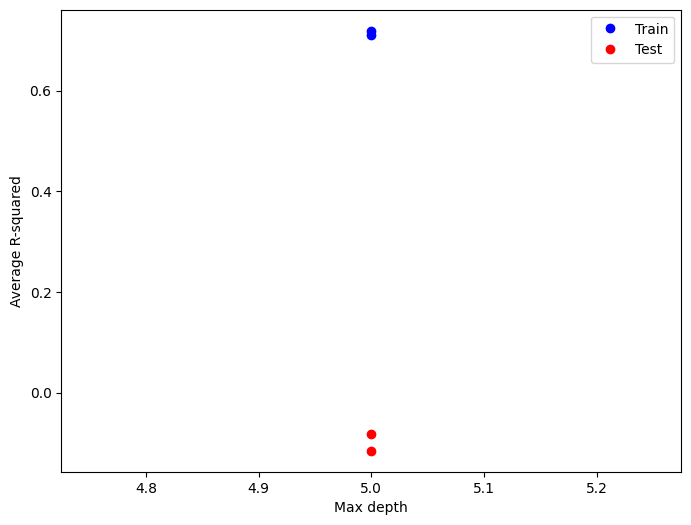

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.plot(np.array(r2["max_depth"]), np.array(r2["Rsquared"]),
         'o',color='blue',label='Train')
plt.plot(np.array(r1["max_depth"]), np.array(r1["Rsquared"]),
         'o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Average R-squared')
plt.legend()
# filename = 'figures\\training_max_depth_corn_cue.png'
# location = os.path.join(cwd, filename)
# fig.savefig(location)

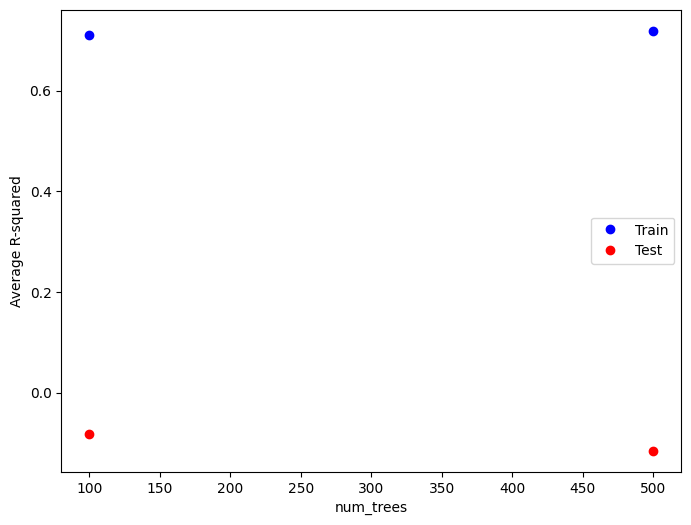

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.plot(np.array(r2["num_trees"]), np.array(r2["Rsquared"]),
         'o',color='blue',label='Train')
plt.plot(np.array(r1["num_trees"]), np.array(r1["Rsquared"]),
         'o',color='red',label='Test')
plt.xlabel('num_trees')
plt.ylabel('Average R-squared')
plt.legend()
# filename = 'figures\\training_num_trees_corn_cue.png'
# location = os.path.join(cwd, filename)
# fig.savefig(location)

### 6. Final Regression

In [ ]:
optimal_num_trees

100

In [ ]:
optimal_depth

5

In [ ]:
# Using the optimal max depth, we fit a random forest model
# with the training data set, and get the test accuracy.
test_X = data_test[features_select].values
test_y = data_test[target].values
clf = RandomForestRegressor(n_estimators=optimal_num_trees,
                            max_depth=optimal_depth,
                            max_features="sqrt")
clf.fit(X,y)

# Test accuracy
train_score = clf.score(X,y)
hold_score = clf.score(test_X, test_y)
print('Training R squared: {:.2f}'.format(train_score))
print('Testing R squared: {:.2f}'.format(hold_score))

Training R squared: 0.63
Testing R squared: 0.05


In [ ]:
predict_test = clf.predict(test_X)
predict_train = clf.predict(X)
df_test = pd.DataFrame(predict_test)
df_train = pd.DataFrame(predict_train)
df_test.columns = ["predicted_value"]
df_train.columns = ["predicted_value"]
df_test['true_value'] = test_y
df_train['true_value'] = y
df_test['dataset'] = 'test'
df_train['dataset'] = 'train'
df_figure = pd.concat([df_test, df_train], ignore_index=True)
RMSE_train = round(np.sqrt(np.mean(np.power(
    df_train['true_value']-df_train['predicted_value'],2))),2)
RMSE_test = round(np.sqrt(np.mean(
    np.power(df_test['true_value']-df_test['predicted_value'],2))),2)

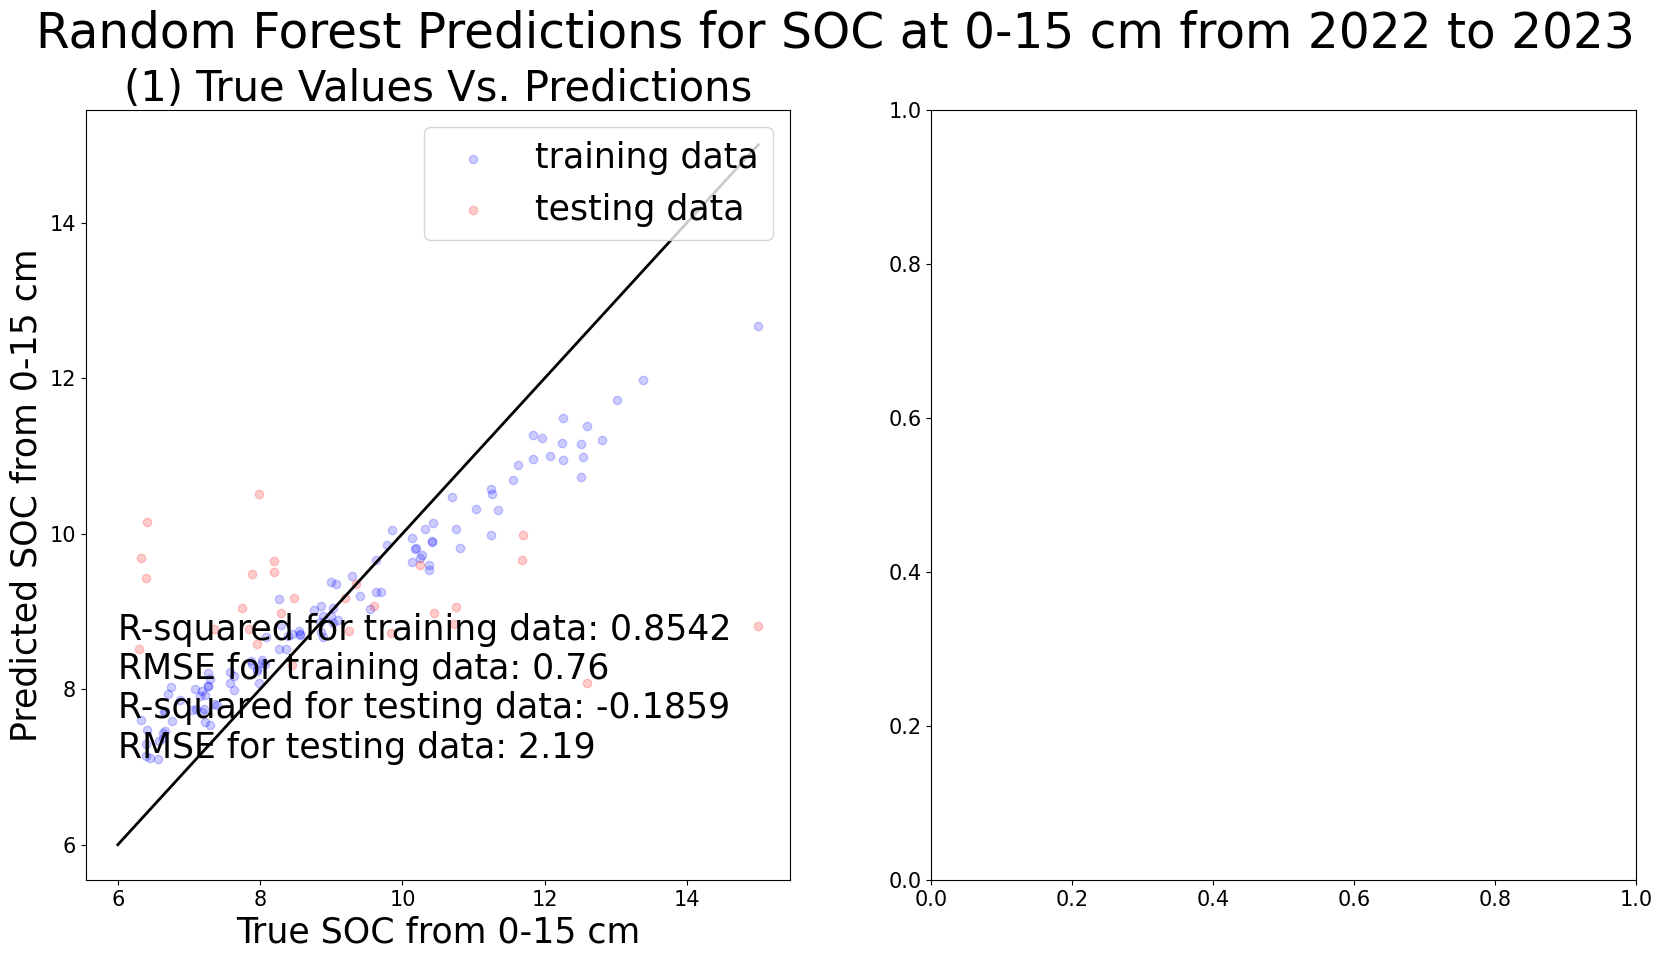

In [ ]:
outputfig, axs = plt.subplots(1, 2, figsize=(20, 10))
outputfig.suptitle('Random Forest Predictions for SOC at 0-15 cm from 2022 to 2023', fontsize=35)
axs[0].scatter(df_train['true_value'],
            df_train['predicted_value'],
            color='blue',
            label='training data',
            alpha=0.2)
axs[0].scatter(df_test['true_value'],
            df_test['predicted_value'],
            color='red',
            label='testing data',
            alpha=0.2)
axs[0].set_xlabel('True SOC from 0-15 cm', fontsize = 25)
axs[0].set_ylabel('Predicted SOC from 0-15 cm', fontsize = 25)
axs[0].legend(loc='upper right', fontsize = 25)
axs[0].set_title('(1) True Values Vs. Predictions',
                    fontsize = 30)
axs[0].plot([6, 15], [6, 15], color = 'black', linewidth = 2)
axs[0].text(6, 7.12, 'R-squared for training data: '+
              str(round(train_score,4)) +
              '\nRMSE for training data: ' +
              str(RMSE_train) +
              '\nR-squared for testing data: ' +
              str(round(hold_score,4)) +
              '\nRMSE for testing data: ' +
              str(RMSE_test), fontsize=25)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

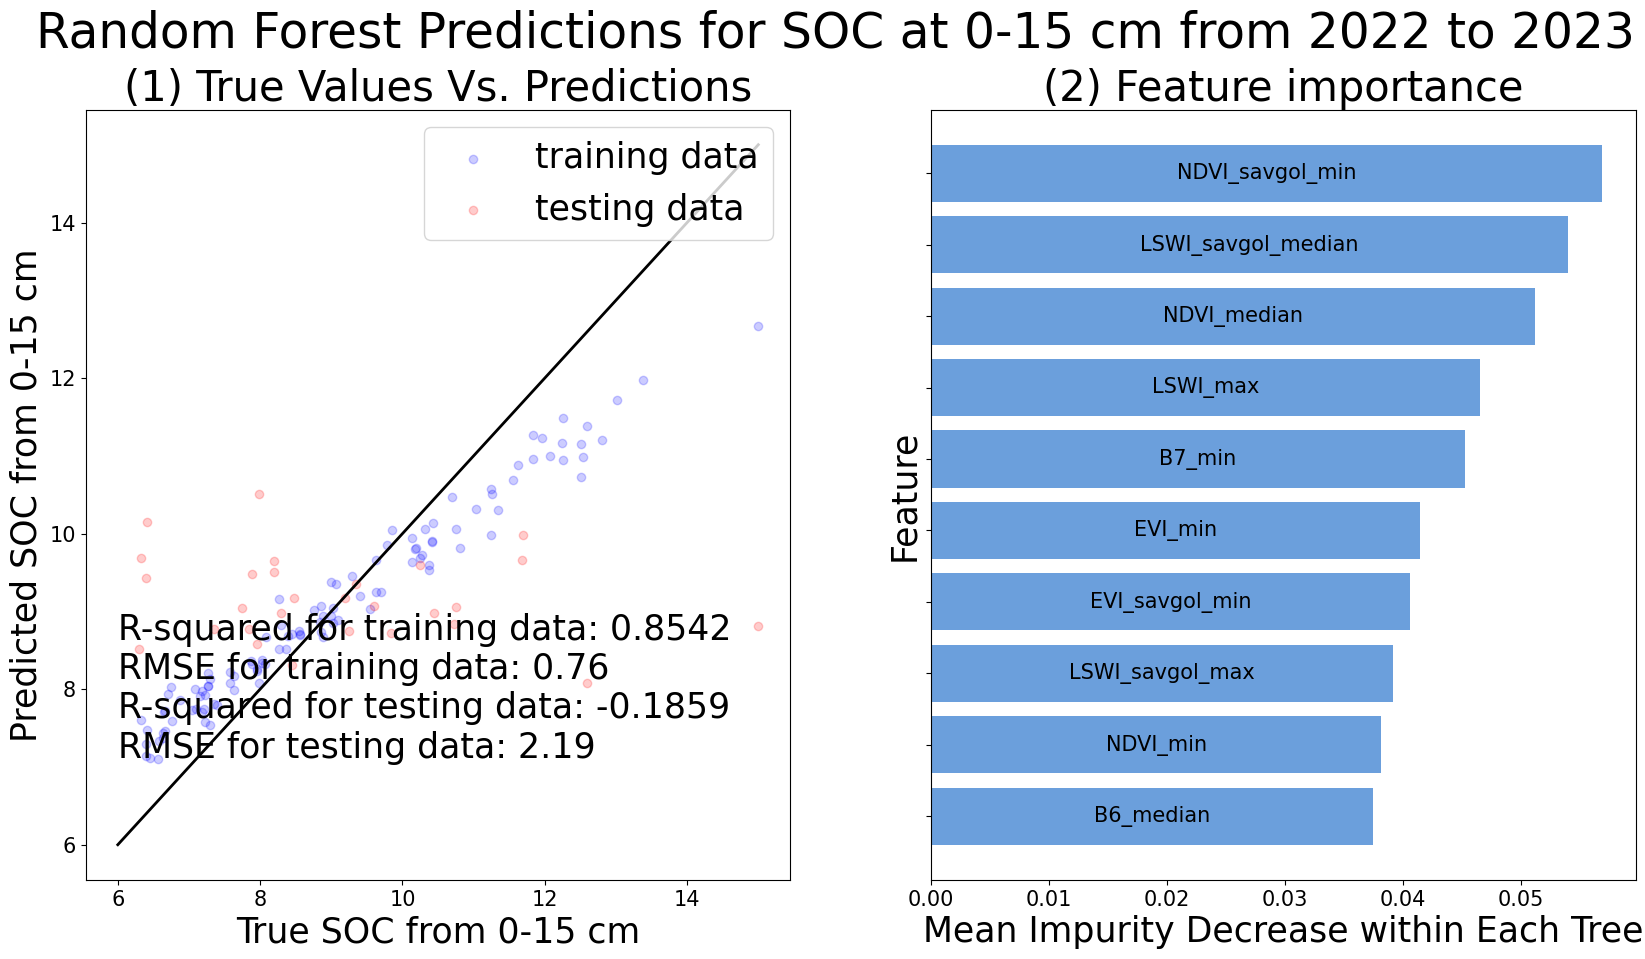

In [ ]:
# Feature importances
importances = clf.feature_importances_
# Sort the importances and get the indices of the top 10
idx = np.argsort(importances)[-10:]

axs[1].set_title('(2) Feature importance',
                    fontsize = 30)
bars=axs[1].barh(range(len(idx)), [importances[i] for i in idx], color='#6b9fdcff')
axs[1].set_yticks(range(len(idx)))
axs[1].set_yticklabels([features_select[i] for i in idx], fontsize=20)
#axs[1].tick_params(axis='y', labelleft=False, labelright=True, labelsize=15)
axs[1].set_xlabel('Mean Impurity Decrease within Each Tree', fontsize = 25)
axs[1].set_ylabel('Feature', fontsize = 25)

# Remove default y-tick labels
axs[1].tick_params(axis='y', labelleft=False, labelright=False)

# Add labels on the bars
for bar, feature in zip(bars, [features_select[i] for i in idx]):
    axs[1].text(
        bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_y() + bar.get_height() / 2,  # Y-coordinate (center of the bar)
        feature,  # Text to display
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        fontsize=15,
        color='black'  # Text color
    )


outputfig
#plt.savefig('outputfig.png', dpi=300, bbox_inches='tight')



#SOC_stock_t_Cha_1530


In [ ]:
SOC_stock_t_Cha_1530=SOC_df[["unique_id","year","SOC_stock_t_Cha_1530"]]
SOC_stock_t_Cha_1530.rename(columns={'unique_id': 'fieldID'},
                  inplace=True)
SOC_stock_t_Cha_1530

<ipython-input-39-5b6bd41a3b03>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOC_stock_t_Cha_1530.rename(columns={'unique_id': 'fieldID'},


,fieldID,year,SOC_stock_t_Cha_1530
0,10101002,2022,9.07
1,10101003,2022,10.19
2,10101004,2022,9.02
3,10101005,2022,10.14
4,10101006,2022,9.55
...,...,...,...
25,20415126,2023,7.18
26,20412109,2023,6.41
27,10104036,2023,15.00
28,20412107,2023,7.98


In [ ]:
final1530_df = aggregated.merge(SOC_stock_t_Cha_1530, on=['fieldID', 'year'])
final1530_df

,fieldID,year,level_1_max,level_1_min,level_1_median,date_max,date_min,date_median,B1_max,B1_min,...,RI_savgol_max,RI_savgol_min,RI_savgol_median,CI_savgol_max,CI_savgol_min,CI_savgol_median,V_savgol_max,V_savgol_min,V_savgol_median,SOC_stock_t_Cha_1530
0,10101002,2022,3822,2902,3362.0,2022-11-28,2022-06-06,2022-10-29,0.085208,0.033515,...,18.563813,10.289627,14.629596,0.126060,-0.040938,0.090583,3.797623,1.654003,2.486271,9.07
1,10101003,2022,3823,2903,3363.0,2022-11-28,2022-06-06,2022-10-29,0.076468,0.029662,...,16.234809,7.945036,10.055997,0.144745,-0.053292,0.095734,3.627500,1.398667,2.224328,10.19
2,10101004,2022,3824,2904,3364.0,2022-11-28,2022-06-06,2022-10-29,0.074587,0.023780,...,12.180114,8.009029,9.444743,0.103413,-0.166070,-0.043724,6.591978,1.644826,3.148579,9.02
3,10101005,2022,3825,2905,3365.0,2022-11-28,2022-06-06,2022-10-29,0.077872,0.028798,...,15.274886,8.244508,10.870906,0.134161,-0.050967,0.094068,4.052111,1.517815,2.240120,10.14
4,10101006,2022,3826,2906,3366.0,2022-11-28,2022-06-06,2022-10-29,0.087745,0.030824,...,14.581866,8.575115,12.237199,0.112497,-0.099680,-0.020847,5.236938,1.533568,3.527426,9.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,20616131,2022,3906,2986,3446.0,2022-11-28,2022-06-06,2022-10-29,0.131979,0.031258,...,18.560105,5.939380,9.200260,0.119108,-0.198206,-0.072300,6.269753,1.911868,4.361924,10.81
135,20616132,2022,3907,2987,3447.0,2022-11-28,2022-06-06,2022-10-29,0.331227,0.025103,...,17.133602,5.129403,11.399686,0.193693,-0.127893,0.039494,4.521653,1.237842,2.239450,6.71
136,20616133,2022,3908,2988,3448.0,2022-11-28,2022-06-06,2022-10-29,0.133676,0.029170,...,14.082027,6.179216,9.248663,0.039182,-0.201923,-0.087100,5.201242,1.394704,3.093504,7.63
137,20616133,2023,4368,2873,3620.5,2023-11-28,2023-06-06,2023-10-24,0.327473,0.000680,...,14.338852,5.322865,7.860970,0.067499,-0.228735,-0.102034,9.265841,0.833827,3.605624,7.63


### 4. Split into Testing and Training Sets

In [ ]:
# Parameters
proportion_test = 0.2
seed_num = 5555
var_list_rf_1530 = ['fieldID', 'year','NDVI_max', 'NDVI_min', 'NDVI_median','EVI_max', 'EVI_min', 'EVI_median',
               'CI_max', 'CI_min', 'CI_median', 'EVI_savgol_max', 'EVI_savgol_min', 'EVI_savgol_median',
               'NDVI_savgol_max', 'NDVI_savgol_min', 'NDVI_savgol_median',
               'CI_savgol_max', 'CI_savgol_min', 'CI_savgol_median',
               'LSWI_max', 'LSWI_min', 'LSWI_median',
               'LSWI_savgol_max', 'LSWI_savgol_min', 'LSWI_savgol_median',
               'B6_max', 'B6_min', 'B6_median', 'B7_max', 'B7_min', 'B7_median', 'SOC_stock_t_Cha_1530']
# Tuning range
max_depth = range(15, 31)
num_trees = [100, 500]
#max_depth = range(15, 31)
#num_trees = [100, 500, 1000, 1500]

In [ ]:
years= final1530_df['year'].to_numpy()


In [ ]:
# Split the data into training and testing sets
df_rf_1530 = final1530_df.loc[:, var_list_rf_1530].dropna(
    subset=['SOC_stock_t_Cha_1530'], how='any').copy()

# Mask the missing data
target = 'SOC_stock_t_Cha_1530'
missing_mask = ~ df_rf_1530[target].isna()
df_rf_1530 = df_rf_1530[missing_mask]

data_train, data_test = train_test_split(df_rf_1530,
                                         test_size=proportion_test,
                                         random_state=seed_num, stratify=years)

In [ ]:
#making sure the stratification worked
#training data percentage of 2023 datapoints/2022
df_2023 = data_train[data_train['year'] == 2023]
df_2022 = data_train[data_train['year'] == 2022]
# Count the number of data points in the filtered DataFrame
count_2023 = len(df_2023)/len(df_2022)
count_2023 #=0.2758
#test data percentage of 2023/2022
dftest_2023 = data_test[data_test['year'] == 2023]
dftest_2022 = data_test[data_test['year'] == 2022]
# Count the number of data points in the filtered DataFrame
countest = len(dftest_2023)/len(dftest_2022)
countest #=0.2727

0.2727272727272727

### 5. Parameter Tuning

In [ ]:
# Use cross validation to find the optimal parameters for each RF model
features = data_train.columns
features_select = list(set(features) -
                       set([target, 'fieldID']))
X = data_train[features_select].values
y = data_train[target].values
result_test = {}
result_train = {}
for t in num_trees:
    for i in max_depth:
        clf = RandomForestRegressor(n_estimators=t,
                                    max_depth=i,
                                    max_features="sqrt")
        scores = cross_validate(clf, X, y,
                                cv=3,
                                return_train_score=True)
        result_test[(i,t)] = scores['test_score'].mean()
        result_train[(i,t)] = scores['train_score'].mean()

In [ ]:
result_test = pd.DataFrame(result_test, index=[0])
result_test = result_test.transpose()
result_train = pd.DataFrame(result_train, index=[0])
result_train = result_train.transpose()
optimal_depth = result_test.idxmax()[0][0]
optimal_num_trees = result_test.idxmax()[0][1]
r1 = pd.DataFrame(result_test).reset_index()
r2 = pd.DataFrame(result_train).reset_index()
r1.columns = ['max_depth', 'num_trees', 'Rsquared']
r2.columns = ['max_depth', 'num_trees', 'Rsquared']

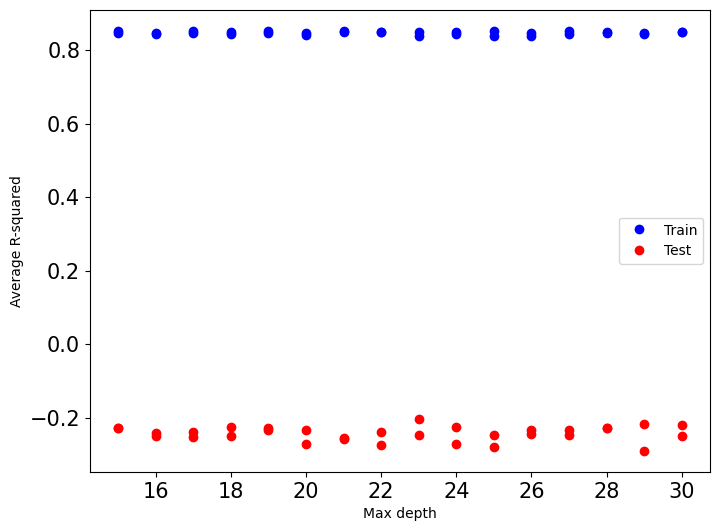

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.plot(np.array(r2["max_depth"]), np.array(r2["Rsquared"]),
         'o',color='blue',label='Train')
plt.plot(np.array(r1["max_depth"]), np.array(r1["Rsquared"]),
         'o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Average R-squared')
plt.legend()
# filename = 'figures\\training_max_depth_corn_cue.png'
# location = os.path.join(cwd, filename)
# fig.savefig(location)

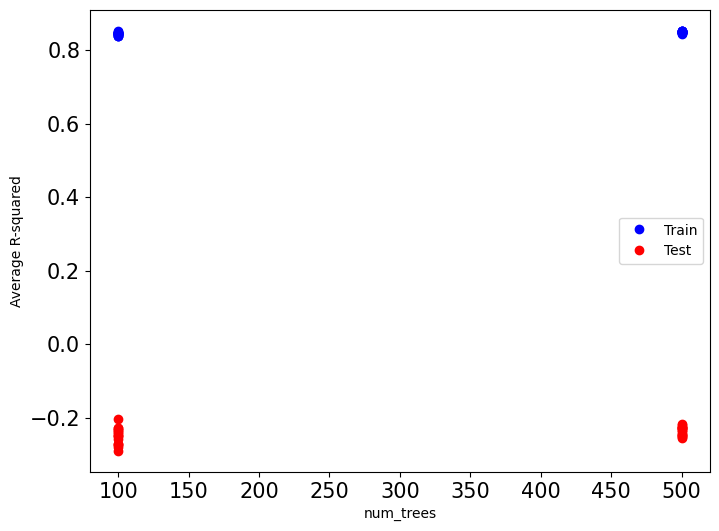

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.plot(np.array(r2["num_trees"]), np.array(r2["Rsquared"]),
         'o',color='blue',label='Train')
plt.plot(np.array(r1["num_trees"]), np.array(r1["Rsquared"]),
         'o',color='red',label='Test')
plt.xlabel('num_trees')
plt.ylabel('Average R-squared')
plt.legend()
# filename = 'figures\\training_num_trees_corn_cue.png'
# location = os.path.join(cwd, filename)
# fig.savefig(location)

### 6. Final Regression

In [ ]:
optimal_num_trees

100

In [ ]:
optimal_depth

23

In [ ]:
# Using the optimal max depth, we fit a random forest model
# with the training data set, and get the test accuracy.
test_X = data_test[features_select].values
test_y = data_test[target].values
clf = RandomForestRegressor(n_estimators=optimal_num_trees,
                            max_depth=optimal_depth,
                            max_features="sqrt")
clf.fit(X,y)

# Test accuracy
train_score = clf.score(X,y)
hold_score = clf.score(test_X, test_y)
print('Training R squared: {:.2f}'.format(train_score))
print('Testing R squared: {:.2f}'.format(hold_score))

Training R squared: 0.85
Testing R squared: -0.19


In [ ]:
predict_test = clf.predict(test_X)
predict_train = clf.predict(X)
df_test = pd.DataFrame(predict_test)
df_train = pd.DataFrame(predict_train)
df_test.columns = ["predicted_value"]
df_train.columns = ["predicted_value"]
df_test['true_value'] = test_y
df_train['true_value'] = y
df_test['dataset'] = 'test'
df_train['dataset'] = 'train'
df_figure = pd.concat([df_test, df_train], ignore_index=True)
RMSE_train = round(np.sqrt(np.mean(np.power(
    df_train['true_value']-df_train['predicted_value'],2))),2)
RMSE_test = round(np.sqrt(np.mean(
    np.power(df_test['true_value']-df_test['predicted_value'],2))),2)

In [ ]:
mae_train=np.mean(np.abs(df_train['true_value']-df_train['predicted_value']))
mae_test=np.mean(np.abs(df_test['true_value']-df_test['predicted_value']))
mae_train
mae_test

1.691192857142857

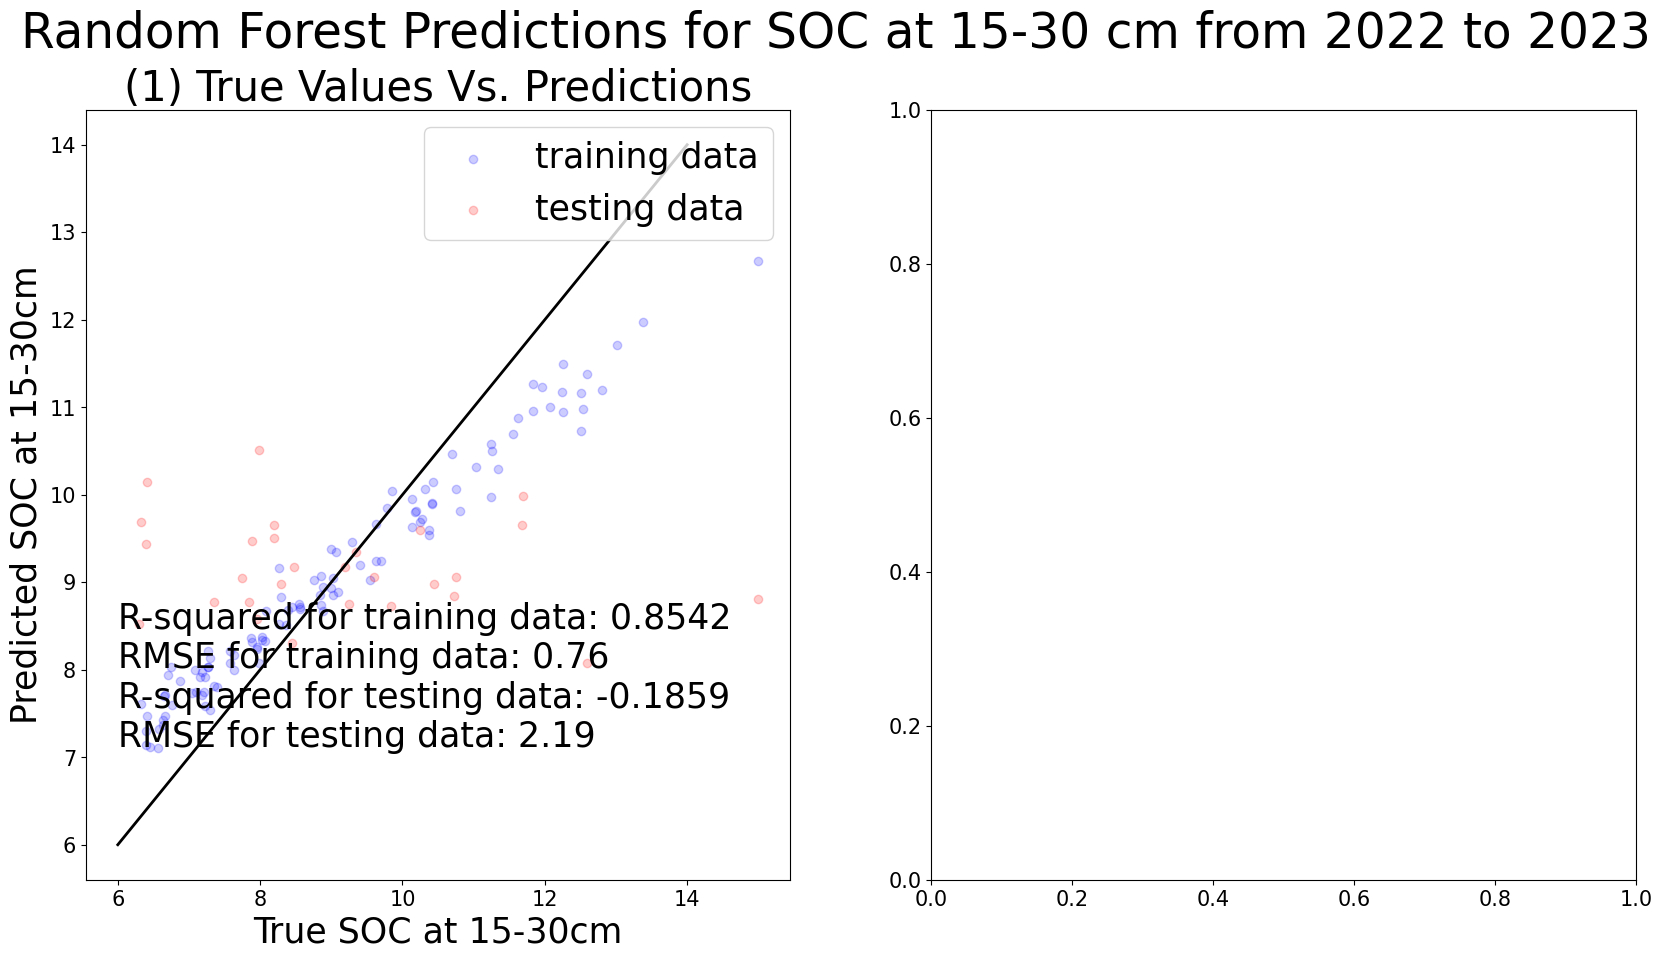

In [ ]:
outputfig2, axs = plt.subplots(1, 2, figsize=(20, 10))
outputfig2.suptitle('Random Forest Predictions for SOC at 15-30 cm from 2022 to 2023', fontsize=35)
axs[0].scatter(df_train['true_value'],
            df_train['predicted_value'],
            color='blue',
            label='training data',
            alpha=0.2)
axs[0].scatter(df_test['true_value'],
            df_test['predicted_value'],
            color='red',
            label='testing data',
            alpha=0.2)
axs[0].set_xlabel('True SOC at 15-30cm', fontsize = 25)
axs[0].set_ylabel('Predicted SOC at 15-30cm', fontsize = 25)
axs[0].legend(loc='upper right', fontsize = 25)
axs[0].set_title('(1) True Values Vs. Predictions',
                    fontsize = 30)
axs[0].plot([6, 14], [6, 14], color = 'black', linewidth = 2)
axs[0].text(6, 7.12, 'R-squared for training data: '+
              str(round(train_score,4)) +
              '\nRMSE for training data: ' +
              str(RMSE_train) +
              '\nR-squared for testing data: ' +
              str(round(hold_score,4)) +
              '\nRMSE for testing data: ' +
              str(RMSE_test), fontsize=25)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

In [ ]:
len(features_select)

31

In [ ]:
idx

array([11,  5, 29, 15,  4, 28,  1, 17, 13, 26])

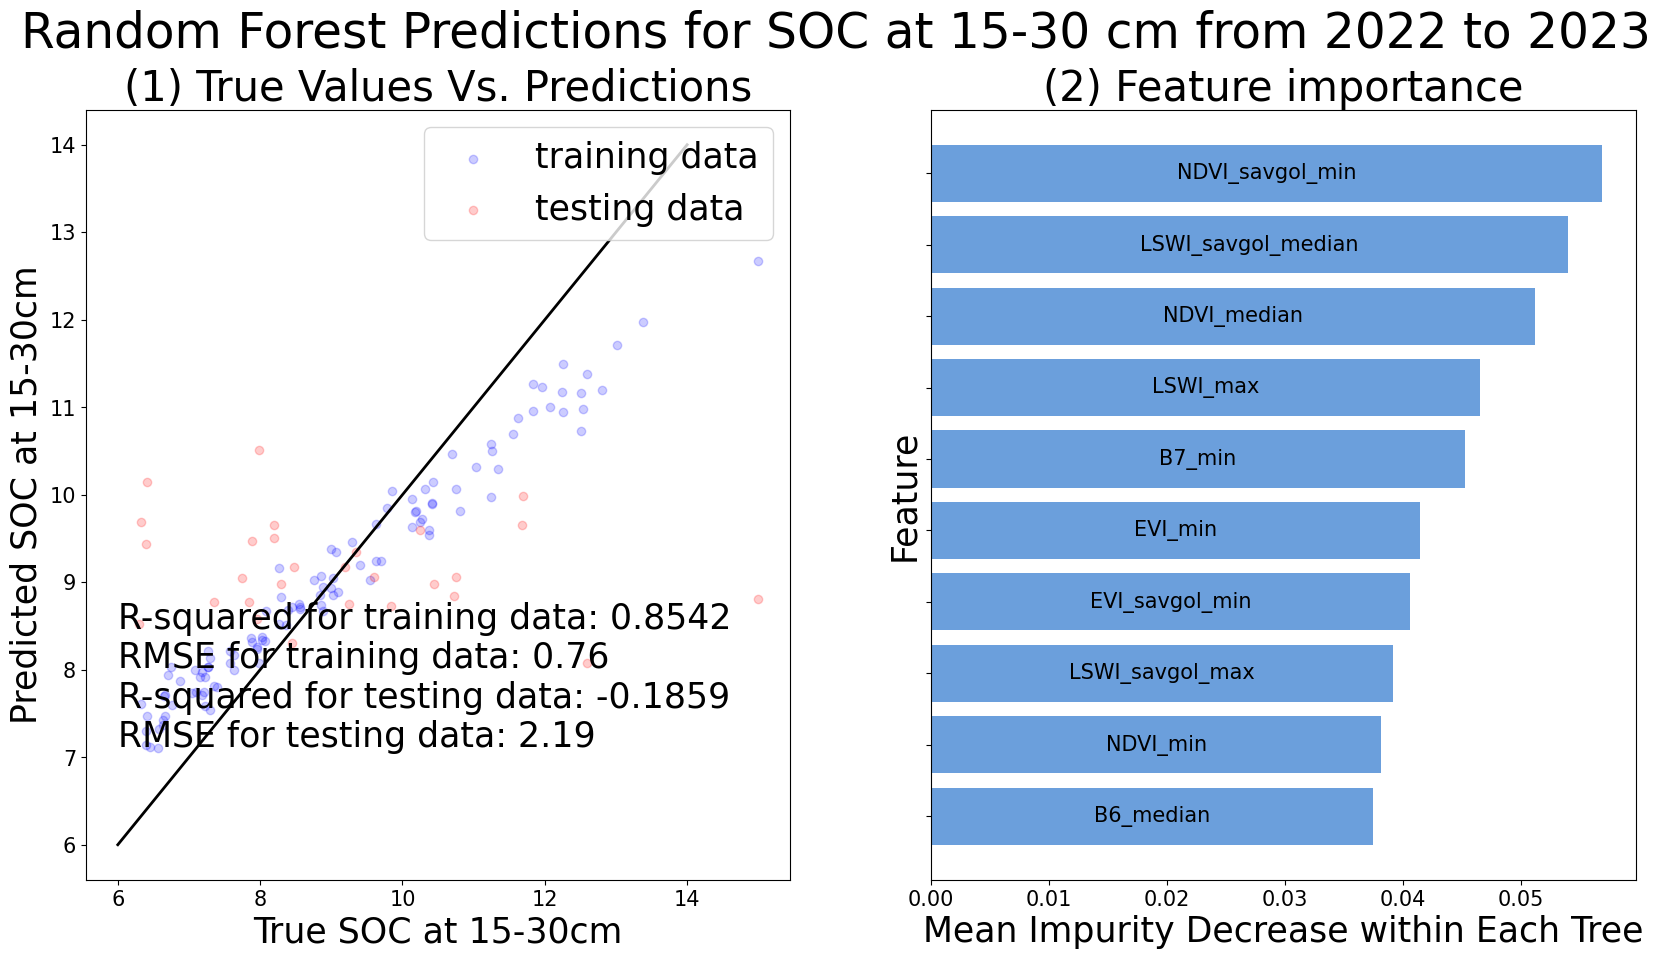

In [ ]:
# Feature importances
importances = clf.feature_importances_
# Sort the importances and get the indices of the top 10
idx = np.argsort(importances)[-10:]

axs[1].set_title('(2) Feature importance',
                    fontsize = 30)
bars=axs[1].barh(range(len(idx)), [importances[i] for i in idx], color='#6b9fdcff')
axs[1].set_yticks(range(len(idx)))
axs[1].set_yticklabels([features_select[i] for i in idx], fontsize=20)
#axs[1].tick_params(axis='y', labelleft=False, labelright=True, labelsize=15)
axs[1].set_xlabel('Mean Impurity Decrease within Each Tree', fontsize = 25)
axs[1].set_ylabel('Feature', fontsize = 25)

# Remove default y-tick labels
axs[1].tick_params(axis='y', labelleft=False, labelright=False)

# Add labels on the bars
for bar, feature in zip(bars, [features_select[i] for i in idx]):
    axs[1].text(
        bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_y() + bar.get_height() / 2,  # Y-coordinate (center of the bar)
        feature,  # Text to display
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        fontsize=15,
        color='black'  # Text color
    )


outputfig2
#plt.savefig('outputfig2.png', dpi=300, bbox_inches='tight')
#features_select= all features (not including the target)
